In [1]:
import numpy as np
import pandas as pd
import evaluate
import warnings
import torch
import os
import random
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

warnings.filterwarnings("ignore", category=FutureWarning)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# 1. Load Data and Basic Preprocessing


In [2]:
df = pd.read_csv('Spam_SMS.csv')
df

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


## General Overview

In [3]:
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nFirst Few Rows:\n", df.head())
print("\nDescriptive Statistics:\n", df.describe())

Dataset Shape: (5574, 2)

Column Data Types:
 Class      object
Message    object
dtype: object

Missing Values:
 Class      0
Message    0
dtype: int64

First Few Rows:
   Class                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Descriptive Statistics:
        Class                 Message
count   5574                    5574
unique     2                    5159
top      ham  Sorry, I'll call later
freq    4827                      30


In [4]:
df['label'] = df['Class'].map({'ham': 0, 'spam': 1})
df = df[['Message', 'label']]

# 2. Exploratory Data Analysis (EDA)
#### Class distribution visualization

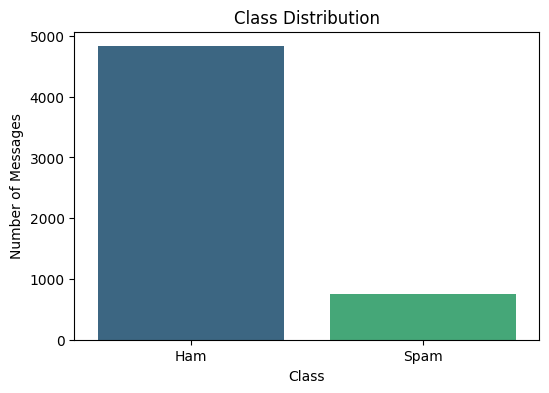

In [5]:
label_counts = df['label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis', dodge=False, legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Messages')
plt.xticks([0,1], ['Ham', 'Spam'])
plt.savefig('Class Distribution.png')
plt.show()

#### Message length distribution


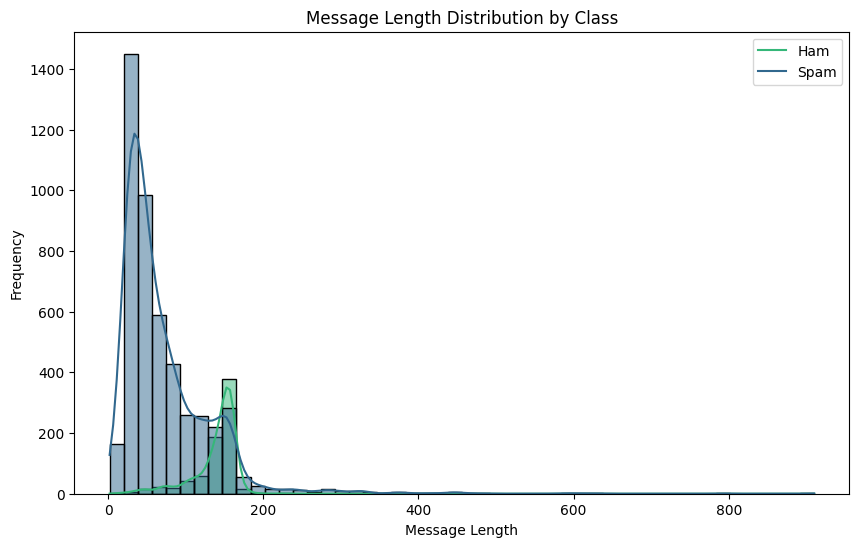

In [6]:
df['message_length'] = df['Message'].apply(len)
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True, palette='viridis')
plt.title('Message Length Distribution by Class')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend(['Ham', 'Spam'])
plt.savefig('Message Length Distribution by Class.png')
plt.show()

#### Word Clouds for Ham and Spam messages

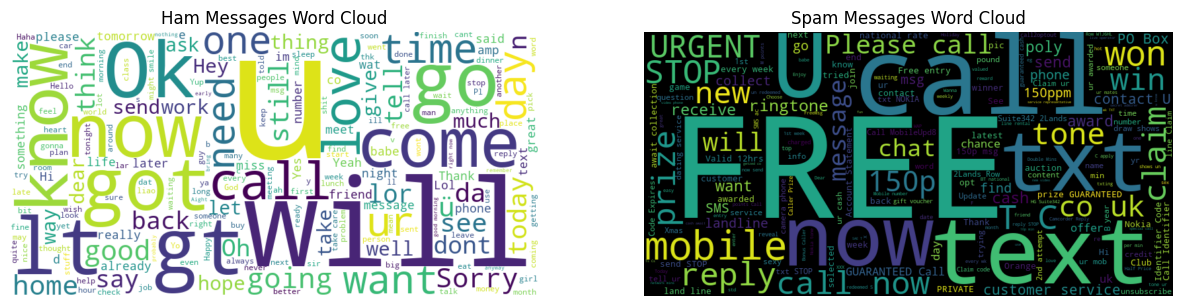

In [7]:
from wordcloud import WordCloud

ham_words = ' '.join(df[df['label'] == 0]['Message'])
wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
spam_words = ' '.join(df[df['label'] == 1]['Message'])
wordcloud_spam = WordCloud(width=800, height=400, background_color='black').generate(spam_words)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Messages Word Cloud')

plt.subplot(1,2,2)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Messages Word Cloud')
plt.savefig('Ham and Spam Messages Word Cloud.png')
plt.show()

# 3. Train-Test Split

In [8]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Message'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels})

# 4. Tokenizer and Model Initialization


In [9]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Preprocessing with Tokenizer


In [10]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

# 6. Define Training Arguments

In [11]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch", 
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,  
    load_best_model_at_end=True,
    report_to="none", 
)

# 7. Define Evaluation Metrics


In [12]:
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return metric.compute(predictions=predictions, references=labels)

# 8. Initialize the Trainer


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# 9. Train the Model


In [14]:
trainer.train()
eval_results = trainer.evaluate()
print(f"Accuracy: {eval_results['eval_accuracy'] * 100:.2f}%")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.026000,0.022814,0.995516
2,0.049900,0.030869,0.992825
3,0.001000,0.027200,0.994619


Accuracy: 99.55%


In [15]:
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)  
labels = predictions.label_ids  

#print(classification_report(labels, preds))
print(classification_report(labels, preds, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       1.00      1.00      1.00       954
        Spam       0.98      0.99      0.98       161

    accuracy                           1.00      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       1.00      1.00      1.00      1115



# 10. Confusion Matrix and Classification Report

<Figure size 600x500 with 0 Axes>

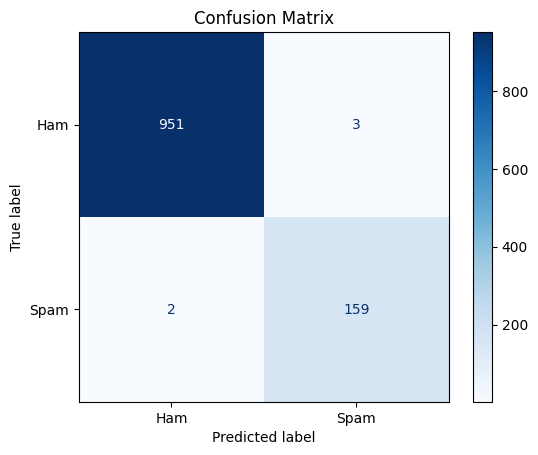

<Figure size 600x500 with 0 Axes>

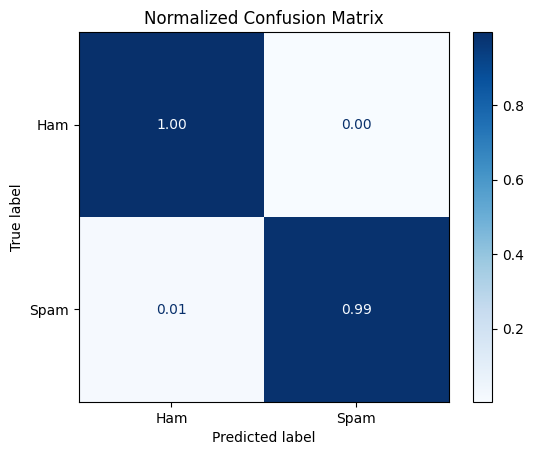

In [16]:
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

cm_normalized = confusion_matrix(labels, preds, normalize='true')
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Ham', 'Spam'])
plt.figure(figsize=(6,5))
disp_normalized.plot(cmap='Blues', values_format='.2f')
plt.title('Normalized Confusion Matrix')
plt.savefig('Confusion Matrix.png')
plt.show()

# 11. Loss and Accuracy Visualization


In [17]:
log_history = trainer.state.log_history

epochs = []
train_loss = []
eval_loss = []
eval_accuracy = []

for log in log_history:
    if 'epoch' in log:
        epochs.append(log['epoch'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_accuracy.append(log['eval_accuracy'])

            
min_length = min(len(epochs), len(train_loss), len(eval_loss), len(eval_accuracy))
epochs = epochs[:min_length]
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]
eval_accuracy = eval_accuracy[:min_length]

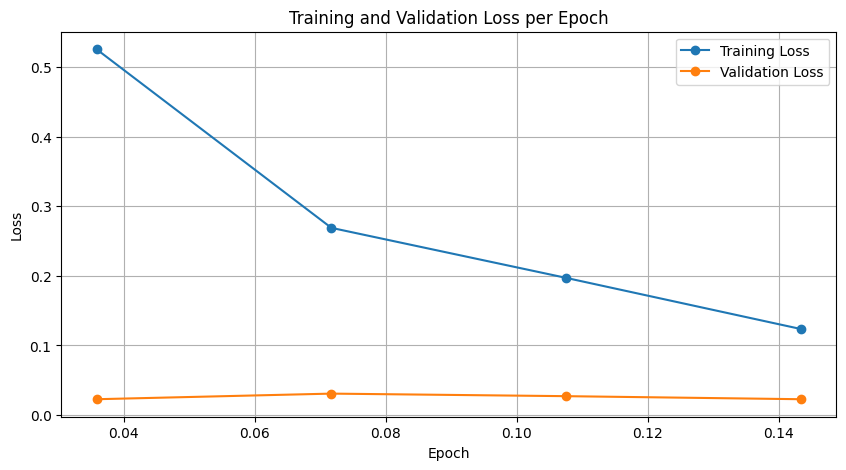

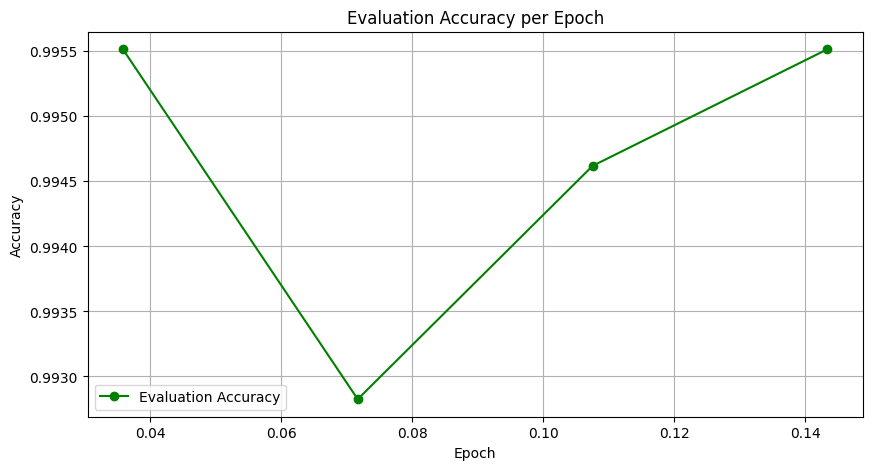

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, eval_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, eval_accuracy, label='Evaluation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('Training and Validation Loss per Epoch.png')
plt.show()

# 12. Test with New Messages

In [19]:
def predict_spam(message):
    inputs = tokenizer(message, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    label = "spam" if predicted_class == 1 else "ham"
    return label

example_messages = [
    "Congratulations! You've won a free ticket to the Bahamas. Call now to claim.",
    "Hey, are we still meeting for lunch today?",
    "Urgent! Your account has been compromised. Please reset your password immediately.",
    "Don't forget to bring the documents to the meeting tomorrow.",
    "You've been selected for a $1000 gift card. Click here to claim now!"
]

for msg in example_messages:
    prediction = predict_spam(msg)
    print(f"Message: \"{msg}\"\nPredicted Label: {prediction}\n")
    
# while True:
#     user_message = input("Enter an SMS message (or type 'exit' to quit): ")
#     if user_message.lower() == 'exit':
#         break
#     prediction = predict_spam(user_message)
#     print(f"Predicted Label: {prediction}\n")

Message: "Congratulations! You've won a free ticket to the Bahamas. Call now to claim."
Predicted Label: spam

Message: "Hey, are we still meeting for lunch today?"
Predicted Label: ham

Message: "Urgent! Your account has been compromised. Please reset your password immediately."
Predicted Label: spam

Message: "Don't forget to bring the documents to the meeting tomorrow."
Predicted Label: ham

Message: "You've been selected for a $1000 gift card. Click here to claim now!"
Predicted Label: spam



# 13. Save the Model


In [20]:
trainer.save_model("./best_model")
loaded_tokenizer = AutoTokenizer.from_pretrained("./best_model")
loaded_model = AutoModelForSequenceClassification.from_pretrained("./best_model")

# SMS Spam Detection Using NLP and Machine Learning

In this project, we aim to classify SMS messages into two categories: **Ham** (legitimate messages) and **Spam** (unwanted or malicious messages). The dataset used consists of SMS messages labeled as either "ham" or "spam". The objective is to build a machine learning model using Natural Language Processing (NLP) to automatically detect spam messages.

We will be using a pre-trained transformer model from the Hugging Face library, `distilbert-base-uncased`, to classify the SMS messages. The process involves tokenizing the text, training a model, evaluating its performance, and visualizing the results.

### Project Outline

1. **Importing Libraries**: Loading necessary libraries and setting up the environment.
2. **Loading Data**: Loading the SMS spam dataset and performing some basic preprocessing.
3. **Exploratory Data Analysis (EDA)**: Visualizing data distributions and exploring the content of messages.
4. **Model Preparation**: Tokenizing text and setting up a transformer-based classification model.
5. **Training the Model**: Training the classification model and evaluating it on a test set.
6. **Results Visualization**: Presenting the results using confusion matrices and performance metrics.
7. **Testing with New Data**: Testing the model with new, unseen messages to predict whether they are spam or ham.
8. **Saving the Model**: Saving the trained model for future use.



## Code Explanation

In this notebook, we have used `transformers` from Hugging Face, which includes a pre-trained `DistilBERT` model for text classification. The key steps are:

1. **Data Loading**: Load the dataset and preprocess it by converting the labels (`ham` and `spam`) into numerical values.
2. **Exploratory Data Analysis (EDA)**: Analyze the distribution of message lengths and the frequency of "ham" vs "spam" messages.
3. **Model Preparation**: We initialize the tokenizer and pre-trained `DistilBERT` model. Tokenization involves converting text into a format that the model can process.
4. **Training and Evaluation**: Using Hugging Face’s `Trainer` API, we set up the model to train on the SMS messages. After training, we evaluate its performance using accuracy and visualize the results through confusion matrices.
5. **Visualization**: After training, the loss and accuracy during training and evaluation are visualized. Confusion matrices show the model's ability to distinguish between "ham" and "spam" messages.
6. **Testing with New Data**: Finally, we test the model on new SMS messages to predict whether they are spam or not.


## Comparison Between "Ham" and "Spam"

In SMS communication, messages can be classified into two main categories: **Ham** (legitimate) and **Spam** (unwanted or malicious). Understanding the distinction between these two types of messages is crucial for developing a robust spam detection system.

### What is "Ham"?

- **Definition**: "Ham" refers to legitimate messages that are not spam. These are typically desired by the recipient.
- **Characteristics**:
  - **Relevant**: Contains information pertinent to the recipient.
  - **Non-Intrusive**: Doesn't disrupt the user's experience.
  - **Consent-Based**: Sent with the recipient's consent or expectation.
- **Examples**:
  - Personal communications between friends and family.
  - Transactional messages like order confirmations or appointment reminders.
  - Service updates from subscribed services.

### What is "Spam"?

- **Definition**: "Spam" refers to unsolicited or unwanted messages, often sent in bulk. These messages can be intrusive and sometimes harmful.
- **Characteristics**:
  - **Unsolicited**: Sent without the recipient’s consent.
  - **Irrelevant**: Contains irrelevant information to the recipient.
  - **Potentially Harmful**: May include phishing attempts, malicious links, or scams.
- **Examples**:
  - Unsolicited advertisements or promotional messages.
  - Phishing attempts that try to trick recipients into giving personal information.
  - Messages containing malicious links.

### Detailed Comparison

| **Aspect**            | **Ham**                                              | **Spam**                                                 |
|-----------------------|------------------------------------------------------|----------------------------------------------------------|
| **Purpose**           | To communicate meaningful and desired information.   | To advertise, scam, or deceive recipients.               |
| **Consent**           | Sent with the recipient's consent or expectation.    | Sent without the recipient's consent.                    |
| **Relevance**         | Highly relevant and personalized to the recipient.   | Often irrelevant and generic.                            |
| **Frequency**         | Sent as needed based on interactions or subscriptions.| Sent in bulk, often multiple times without engagement.   |
| **Content Quality**   | High-quality, well-crafted messages.                 | Low-quality, sometimes misleading or harmful content.     |
| **User Experience**   | Enhances user experience by providing useful info.   | Deteriorates user experience by cluttering inboxes.       |
| **Legal Compliance**  | Generally complies with communication regulations.   | Often violates regulations like the CAN-SPAM Act or GDPR. |
| **Examples**          | - Personal texts<br>- Bank alerts<br>- Service updates| - Unsolicited ads<br>- Phishing emails<br>- Malware links |

### Importance of Distinguishing Between "Ham" and "Spam"

1. **User Satisfaction**: Proper filtering ensures that only relevant and desired messages reach users.
2. **Security**: Blocking spam messages, especially those containing phishing attempts or malware, enhances user security.
3. **Efficiency**: Reducing spam improves the user's experience by decluttering their inbox.
4. **Resource Management**: Managing spam helps to minimize the overuse of network resources by preventing unnecessary transmission of messages.

### Conclusion

By distinguishing between **ham** and **spam**, we ensure that the integrity and security of communication channels are maintained. This classification helps improve user experience and prevents malicious activities. The model developed in this project uses NLP to effectively detect and classify spam messages, helping to create a more efficient messaging environment.
